In [1]:
import numpy as np
import cv2
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image, ImageDraw 
import argparse
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import time

In [2]:
from torchvision import models
class Net_res(torch.nn.Module):
    def __init__(self):
        '''
        初始化一些层，使用resnet18作为backbone
        backbone最后一层输出改变成18
        '''
        super(Net_res,self).__init__()
        self.resnet18 = models.resnet18(pretrained= True)
        self.resnet18.fc = torch.nn.Linear(in_features=512, out_features= 256, bias= True)
        self.last_fc = torch.nn.Linear(256, 18, bias= True)
        self.prelu = torch.nn.PReLU()
    
    def forward(self, x):
        '''
        传播过程
        '''
        #输入尺寸为224*224
        x = self.resnet18(x)
        x = self.prelu(x)
        x = self.last_fc(x)
        return x

In [40]:
class Normalize(object):
    """
        Resieze to train_boarder x train_boarder. Here we use 224 x 224
        Then do channel normalization: (image - mean) / std_variation
    """
    def __init__(self,train_boarder= 224):
        self.train_boarder = train_boarder
    def __call__(self,sample):
        img, w, h = sample['image'], sample['w'], sample['h']
        img_resize = np.asarray(img.resize((self.train_boarder, self.train_boarder),Image.BILINEAR))
        return {'image':img_resize, 'image_ori':np.asarray(img), 'w' : w, 'h' : h}

In [41]:
class ToTensor(object):
    """
        Convert ndarrays in sample to Tensors.
        Tensors channel sequence: N x C x H x W
    """
    def __call__(self,sample):
        '''
        numpy img: H*W*C
        torch.tensorimg: N*C*H*W
        '''
        img, w, h = sample['image'], sample['w'], sample['h']
#         如果不是灰度图要改变维度
        img_transposed = img.transpose((2, 0, 1))
        return {'image':torch.from_numpy(img_transposed).float(), 'image_ori':sample['image_ori'], 'w' : w, 'h' : h}

In [57]:
class FaceLandmarksDataset():
    def __init__(self, data, transforms= None, train_boarder= 224):
        '''
        :param lines: src_line
        :param transform: data transform
        '''
        self.data = data
        self.transforms = transforms
        self.train_boarder = train_boarder
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data.values[idx][0]
        #打开图片
        img = Image.open(img)
        
        #对lanmarks做变换
        w = img.width
        h = img.height
        
        sample = {'image':img, 'w' : w, 'h' : h}
    
        sample = self.transforms(sample)
        return sample

In [43]:
def load_data(filepath):
    '''
    加载数据
    '''
    df = pd.read_csv(filepath)
    tsfm = transforms.Compose([
        Normalize(),
        ToTensor()]
    )
    data_set = FaceLandmarksDataset(df, transforms= tsfm)
    return data_set


In [68]:
def main():
    t1 = time.time()
    path = 'data/test.csv'
    predict_set = load_data(path)
    predict_loader = torch.utils.data.DataLoader(predict_set, batch_size= 1)
    path_model = 'trained_models_Copy2/detector_epoch_100.pt'
    device = 'cuda'
    model = Net_res().to(device)
    model.load_state_dict(torch.load(path_model, map_location= device))
    model.eval()
    t2 = time.time()
    landmarks = []
    with torch.no_grad():
        for i, data in enumerate(predict_loader):
            if i % 100 == 0:
                print('正在处理第{}张猫片'.format(i))
            img = data['image'].to(device)
            w = data['w'].item()
            h = data['h'].item()
            output_pts = model(img)
            output_pts = output_pts[0].cpu().numpy()
            output_pts[::2] = output_pts[::2]/224*w
            output_pts[1::2] = output_pts[1::2]/224*h
            landmarks.append(output_pts)
    t3 = time.time()
    print(t2 - t1)
    print(t3 - t2)
    return np.array(landmarks)

In [69]:
if __name__ == '__main__':
    landmarks = main()

正在处理第0张猫片
正在处理第100张猫片
正在处理第200张猫片
正在处理第300张猫片
正在处理第400张猫片
正在处理第500张猫片
正在处理第600张猫片
正在处理第700张猫片
正在处理第800张猫片
正在处理第900张猫片
正在处理第1000张猫片
正在处理第1100张猫片
正在处理第1200张猫片
正在处理第1300张猫片
正在处理第1400张猫片
正在处理第1500张猫片
正在处理第1600张猫片
正在处理第1700张猫片
正在处理第1800张猫片
正在处理第1900张猫片
正在处理第2000张猫片
正在处理第2100张猫片
正在处理第2200张猫片
正在处理第2300张猫片
正在处理第2400张猫片
正在处理第2500张猫片
正在处理第2600张猫片
正在处理第2700张猫片
正在处理第2800张猫片
正在处理第2900张猫片
正在处理第3000张猫片
正在处理第3100张猫片
正在处理第3200张猫片
正在处理第3300张猫片
正在处理第3400张猫片
正在处理第3500张猫片
正在处理第3600张猫片
正在处理第3700张猫片
正在处理第3800张猫片
正在处理第3900张猫片
正在处理第4000张猫片
正在处理第4100张猫片
正在处理第4200张猫片
正在处理第4300张猫片
正在处理第4400张猫片
正在处理第4500张猫片
正在处理第4600张猫片
正在处理第4700张猫片
正在处理第4800张猫片
正在处理第4900张猫片
正在处理第5000张猫片
正在处理第5100张猫片
正在处理第5200张猫片
正在处理第5300张猫片
正在处理第5400张猫片
正在处理第5500张猫片
正在处理第5600张猫片
正在处理第5700张猫片
正在处理第5800张猫片
正在处理第5900张猫片
正在处理第6000张猫片
正在处理第6100张猫片
正在处理第6200张猫片
正在处理第6300张猫片
正在处理第6400张猫片
正在处理第6500张猫片
正在处理第6600张猫片
正在处理第6700张猫片
正在处理第6800张猫片
正在处理第6900张猫片
正在处理第7000张猫片
正在处理第7100张猫片
正在处理第7200张猫片
正在处理第7300张猫片
正在处理第7400张猫片
正在处理第7500张猫片
正在处理第7600张猫片
正在处理第7700张猫

In [70]:
pd.DataFrame(landmarks).to_csv('data/results.csv')

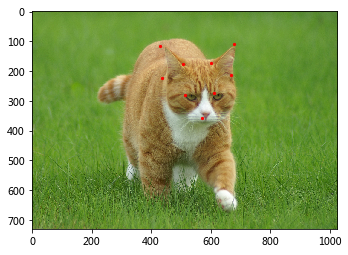

1.376209020614624
0.46158337593078613


In [67]:
t1 = time.time()
path = 'data/test.csv'
predict_set = load_data(path)
predict_loader = torch.utils.data.DataLoader(predict_set, batch_size= 1)
path_model = 'trained_models_Copy2/detector_epoch_100.pt'
device = 'cuda'
model = Net_res().to(device)
model.load_state_dict(torch.load(path_model, map_location= device))
model.eval()
idx = 15
t2 = time.time()
landmarks = []
with torch.no_grad():
    for i,data in enumerate(predict_loader):
        if i == idx:
            img = data['image'].to(device)
            w = data['w'].item()
            h = data['h'].item()
            img_ori = data['image_ori']
            output_pts = model(img)
            landmarks = output_pts[0].cpu().numpy()
            
            xs = landmarks[::2]/224*w
            ys = landmarks[1::2]/224*h
            plt.imshow(img_ori[0].numpy())
            plt.scatter(xs,ys,s = 5, c = 'r', edgecolors= 'r')
            plt.show()
        elif i > idx:
            break
t3 = time.time()
print(t2 - t1)
print(t3 - t2)

In [ ]:
img = Image.open('data/test/0.jpg')

img_resize = np.asarray(img.resize((224, 224),Image.BILINEAR))

img_tensor = torch.from_numpy(img_resize.transpose((2, 0, 1))).float()

path_model = 'trained_models_Copy2/detector_epoch_100.pt'
model = Net_res()
device = 'cpu'
model.load_state_dict(torch.load(path_model, map_location= device))
model.eval()
with torch.no_grad():
    out = model(img_tensor.unsqueeze(0))

xs = out[0,::2]
ys = out[0,1::2]

plt.imshow(img_resize)
plt.scatter(xs,ys,s = 5, c = 'r', edgecolors= 'r')
plt.show()